In [24]:
import cv2
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt

In [25]:
# Function to load YOLO
def load_yolo(config_path, weights_path):
    net = cv2.dnn.readNet(weights_path, config_path)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return net, output_layers

In [26]:

# Function to load classes
def load_classes(classes_file):
    with open(classes_file, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

In [27]:
# Function to detect defects using YOLO and classify using VGG16
def detect_defects_yolo(image_path, net, output_layers, classes, vgg_model):
    img = cv2.imread(image_path)
    height, width, channels = img.shape

    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Confidence threshold
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    detected_regions = []
    detected_boxes = []
    detected_labels = []

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            detected_regions.append(img[y:y+h, x:x+w])  # Extract region of interest
            detected_boxes.append((x, y, x+w, y+h))  # Store box coordinates

            # Perform classification using VGG16 model
            region_img = cv2.resize(img[y:y+h, x:x+w], (64, 64))  # Resize image to VGG16 input size
            region_img = cv2.cvtColor(region_img, cv2.COLOR_BGR2RGB)  # Convert to RGB (VGG16 expects RGB)
            region_img = region_img.astype(np.float32) / 255.0  # Normalize

            # Predict using VGG16 model
            prediction = vgg_model.predict(np.expand_dims(region_img, axis=0))
            predicted_class = np.argmax(prediction)
            label = classes[predicted_class]
            detected_labels.append(label)

            # Draw rectangle and label on the original image
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return img, detected_regions, detected_boxes, detected_labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


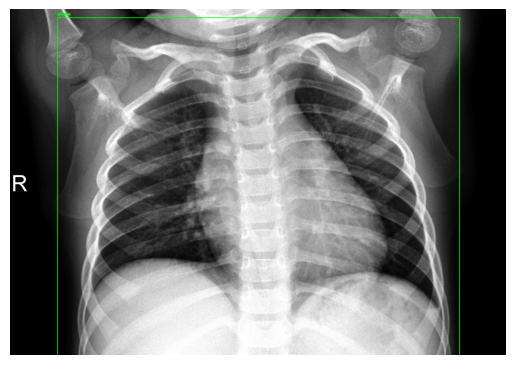

In [32]:
# Load YOLO
config_path = 'yolo/yolov4.cfg'
weights_path = 'yolo/yolov4.weights'
net, output_layers = load_yolo(config_path, weights_path)

# Load YOLO classes
classes_file = 'yolo/coco.names'
classes = load_classes(classes_file)

# Load VGG16 model
model_vgg16_path = 'models/model_vgg16.h5'
model_vgg16 = load_model(model_vgg16_path)
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Example image path
image_path = r'Covid-19\test\Normal\0109.jpeg'

# Detect defects using YOLO and classify using VGG16
img, detected_regions, detected_boxes, detected_labels = detect_defects_yolo(image_path, net, output_layers, classes, model_vgg16)

# Draw rectangles on the image for detected regions and display labels
for (x1, y1, x2, y2), label in zip(detected_boxes, detected_labels):
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with rectangles and labels
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


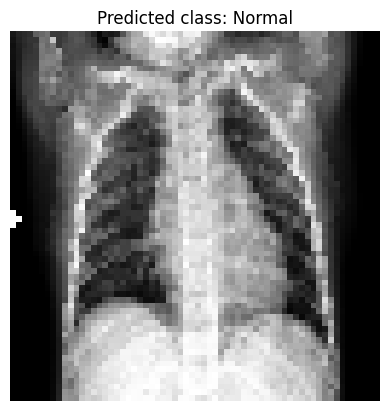

In [29]:
# Single image classification using VGG16
img_path = r'Covid-19\test\Normal\0109.jpeg'
img = image.load_img(img_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize the image as per training data

# Predict the class label using the VGG16 model
prediction_vgg16 = model_vgg16.predict(img_array)
predicted_class_vgg16 = np.argmax(prediction_vgg16)
class_labels = ["Covid", "Normal", "Viral Pneumonia"]
predicted_label_vgg16 = class_labels[predicted_class_vgg16]

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title("Predicted class: " + predicted_label_vgg16)  # Add title with predicted label
plt.show()
